In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [86]:
# Feature lists
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower", "mid_price_variation", "mid_price_volatility"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features

In [87]:
sampling_rate = "1s"
prediction_columns = ["mid_price_variation", "mid_price_volatility"]
batch_size = 32
epochs = 2
look_back = 32

In [88]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-02"
end_date = "2024-10-03"

all_data = process_and_combine_data(start_date, end_date, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'mid_price_first', 'mid_price_high',
       'mid_price_low', 'mid_price_last', 'close', 'high', 'low', 'open',
       'mid_price_variation', 'mid_price_volatility', 'Returns',
       'Target_close', 'ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5',
       'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15',
       'OHH3', 'OHH5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7',
       'AO_5_10', 'EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20',
       'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)', 'Bollinger_Upper',
       'Bollinger_Lower', 'U_minus_L', 'MA20dSTD', 'CO', 'C1O1', 'C2O2',
       'C3O3', 'range', 'OH1', 'time_since_open', 'dow_2', 'dow_3',
       'market_session'],
      dtype='object')


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_first,mid_price_high,mid_price_low,mid_price_last,close,high,...,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,dow_2,dow_3,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 09:30:26-04:00,824.0,0.0,-477.0,434.0,225.875,225.880,225.860,225.870,225.85,225.86,...,-0.005,0.095,-0.055,-0.010,0.020,0.110,26.0,1,0,0
2024-10-02 09:30:28-04:00,849.0,0.0,526.0,389.0,225.875,225.875,225.840,225.845,225.82,225.86,...,-0.030,-0.005,0.095,-0.055,0.035,0.005,28.0,1,0,0
2024-10-02 09:30:30-04:00,1245.0,1007.0,-280.0,907.0,225.845,225.960,225.845,225.950,225.93,225.94,...,0.105,-0.030,-0.005,0.095,0.115,0.000,30.0,1,0,0
2024-10-02 09:30:31-04:00,0.0,0.0,-398.0,158.0,225.950,225.950,225.950,225.950,225.93,225.94,...,0.000,0.105,-0.030,-0.005,0.000,0.115,31.0,1,0,0
2024-10-02 09:30:33-04:00,2678.0,114.0,1417.0,-1324.0,226.000,226.000,225.915,225.915,225.90,225.99,...,-0.085,0.000,0.105,-0.030,0.085,0.000,33.0,1,0,0


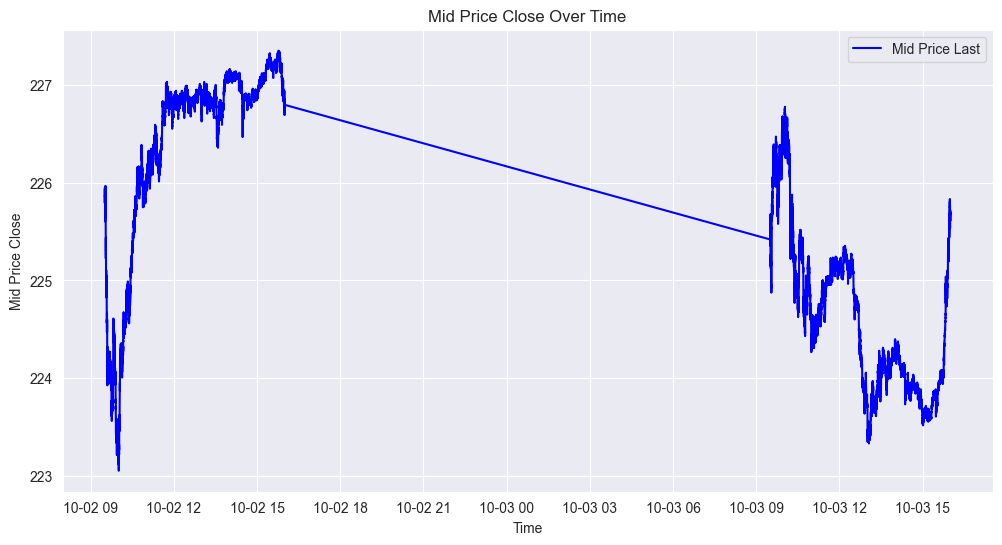

In [89]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["mid_price_last"], label="Mid Price Last", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [90]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [91]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scalers on the training data
standard_scaler = StandardScaler().fit(train_df[standard_features])
minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[minmax_features])

# Apply scalers to training data
train_df.loc[:, standard_features] = standard_scaler.transform(train_df[standard_features])
train_df.loc[:, minmax_features] = minmax_scaler.transform(train_df[minmax_features])

# Apply scalers to validation data
val_df.loc[:, standard_features] = standard_scaler.transform(val_df[standard_features])
val_df.loc[:, minmax_features] = minmax_scaler.transform(val_df[minmax_features])

# Apply scalers to test data
test_df.loc[:, standard_features] = standard_scaler.transform(test_df[standard_features])
test_df.loc[:, minmax_features] = minmax_scaler.transform(test_df[minmax_features])

# Scale target variables
target_scaler = StandardScaler()
train_df.loc[:, prediction_columns] = target_scaler.fit_transform(train_df[prediction_columns])
val_df.loc[:, prediction_columns] = target_scaler.transform(val_df[prediction_columns])
test_df.loc[:, prediction_columns] = target_scaler.transform(test_df[prediction_columns])

In [92]:
from tensorflow.keras.utils import Sequence

class BinaryOutputTimeseriesGenerator(Sequence):
    def __init__(self, data, targets, look_back, batch_size):
        self.data = data
        self.targets = targets
        self.look_back = look_back
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.data) - self.look_back) // self.batch_size

    def __getitem__(self, idx):
        X = []
        y1 = []
        y2 = []

        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            X.append(self.data[i: i + self.look_back])
            y1.append(self.targets[i + self.look_back, 0])  # mid_price_variation
            y2.append(self.targets[i + self.look_back, 1])  # mid_price_volatility

        return np.array(X), {"mid_price_variation": np.array(y1), "mid_price_volatility": np.array(y2)}

In [93]:
# Convert data to NumPy arrays
train_X = train_df[features].values
train_y = train_df[prediction_columns].values

val_X = val_df[features].values
val_y = val_df[prediction_columns].values

test_X = test_df[features].values
test_y = test_df[prediction_columns].values

# Create generators
train_gen = BinaryOutputTimeseriesGenerator(train_X, train_y, look_back=look_back, batch_size=batch_size)
val_gen = BinaryOutputTimeseriesGenerator(val_X, val_y, look_back=look_back, batch_size=batch_size)
test_gen = BinaryOutputTimeseriesGenerator(test_X, test_y, look_back=look_back, batch_size=1)


In [94]:
from tensorflow.keras import layers, Model, optimizers

# Define the model
input_size = len(features)

inputs = layers.Input(shape=(look_back, input_size))
x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Two outputs for regression
mid_price_variation_output = layers.Dense(1, name="mid_price_variation")(x)  # Output 1
mid_price_volatility_output = layers.Dense(1, name="mid_price_volatility")(x)  # Output 2

# Create and compile the model
model = Model(inputs=inputs, outputs=[mid_price_variation_output, mid_price_volatility_output])
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={"mid_price_variation": "mean_squared_error", "mid_price_volatility": "mean_squared_error"},
    metrics={"mid_price_variation": "mae", "mid_price_volatility": "mae"},
)

# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/2


c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 2.7399 - mid_price_variation_loss: 1.3516 - mid_price_variation_mae: 0.8275 - mid_price_volatility_loss: 1.3884 - mid_price_volatility_mae: 0.8956 - val_loss: 1.7894 - val_mid_price_variation_loss: 1.0079 - val_mid_price_variation_mae: 0.7792 - val_mid_price_volatility_loss: 0.7815 - val_mid_price_volatility_mae: 0.7309
Epoch 2/2
781/781 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 2.0375 - mid_price_variation_loss: 1.0222 - mid_price_variation_mae: 0.6722 - mid_price_volatility_loss: 1.0153 - mid_price_volatility_mae: 0.7798 - val_loss: 1.7001 - val_mid_price_variation_loss: 0.7521 - val_mid_price_variation_mae: 0.6534 - val_mid_price_volatility_loss: 0.9479 - val_mid_price_volatility_mae: 0.8304


In [96]:
# Evaluate the model
test_results = model.evaluate(test_gen)
print("Test Total Loss:", test_results[0])  # Combined loss for all outputs

print("Test Loss (Returns):", test_results[1])
print("Test MAE (Returns):", test_results[3])

print("Test Loss (Volatilities):", test_results[2])
print("Test MAE (Volatilities):", test_results[4])

test_timestamps = test_df.index[look_back:]
# Make predictions
predictions = model.predict(test_gen)
predicted_variation, predicted_volatility = predictions


# Stack both predicted outputs together to match the scaler's expected input shape
predictions_stacked = np.column_stack([predicted_variation, predicted_volatility])

# Apply inverse transform
predictions_unscaled = target_scaler.inverse_transform(predictions_stacked)

# Extract individual values
predicted_variation = predictions_unscaled[:, 0]
predicted_volatility = predictions_unscaled[:, 1]


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1.7601 - mid_price_variation_loss: 0.7768 - mid_price_variation_mae: 0.6503 - mid_price_volatility_loss: 0.9833 - mid_price_volatility_mae: 0.8342
Test Total Loss: 1.7634713649749756
Test Loss (Returns): 0.7531060576438904
Test MAE (Returns): 0.6125549674034119
Test Loss (Volatilities): 1.0103667974472046
Test MAE (Volatilities): 0.8540511727333069
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


In [1]:

plt.figure(figsize=(12, 6))
plt.plot(test_timestamps, test_y[look_back:, 0], label="Actual Mid Price Variation", color="black", linestyle="dashed")
plt.plot(test_timestamps, predicted_variation, label="Predicted Mid Price Variation", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Variation")
plt.title("Predicted vs Actual Mid Price Variation")
plt.legend()
plt.xticks(rotation=45)
plt.show()


NameError: name 'plt' is not defined

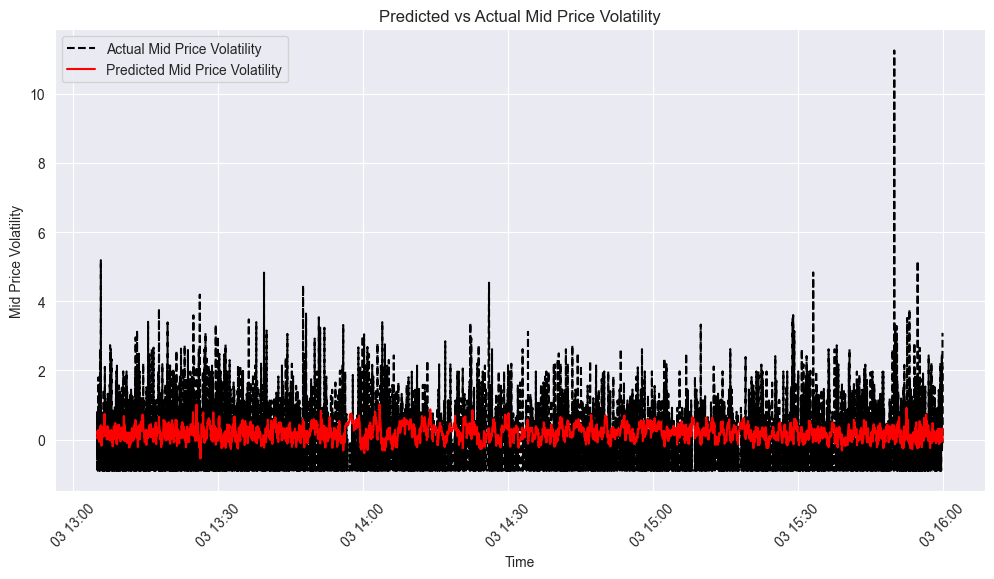

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(test_timestamps, test_y[look_back:, 1], label="Actual Mid Price Volatility", color="black", linestyle="dashed")
plt.plot(test_timestamps, predicted_volatility, label="Predicted Mid Price Volatility", color="red")
plt.xlabel("Time")
plt.ylabel("Mid Price Volatility")
plt.title("Predicted vs Actual Mid Price Volatility")
plt.legend()
plt.xticks(rotation=45)
plt.show()
